## Binary classification: WAAT
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different classification techniques for characterizing users' warmth-attractiveness (WAAT). 

* Thesholding continuous scores generated from [factor analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics/tree/master/speaker_characteristics/factor_analysis) based on percentiles to define 3 classes ("high", "mid", and "low") with approximately the same number of samples.
* Only the "high" and "low" classes are of interest -> I address **binary classification**.
* As evaluation metric, I will consider the average per-class accuracy (average of sensitivity and specificity)

In [1]:
import io
import requests
import time # for timestamps
import pickle # save models

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp after tuner

from cls_tuning import * # my helper functions

from sklearn.metrics import recall_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Load features and labels

In [3]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

In [4]:
# extracting scores

feats_ratings_scores_all = feats_ratings_scores_train.append(feats_ratings_scores_test)

scores = feats_ratings_scores_all.groupby(['spkID','speaker_gender']).mean()[traits_names]
scores.reset_index(inplace=True)


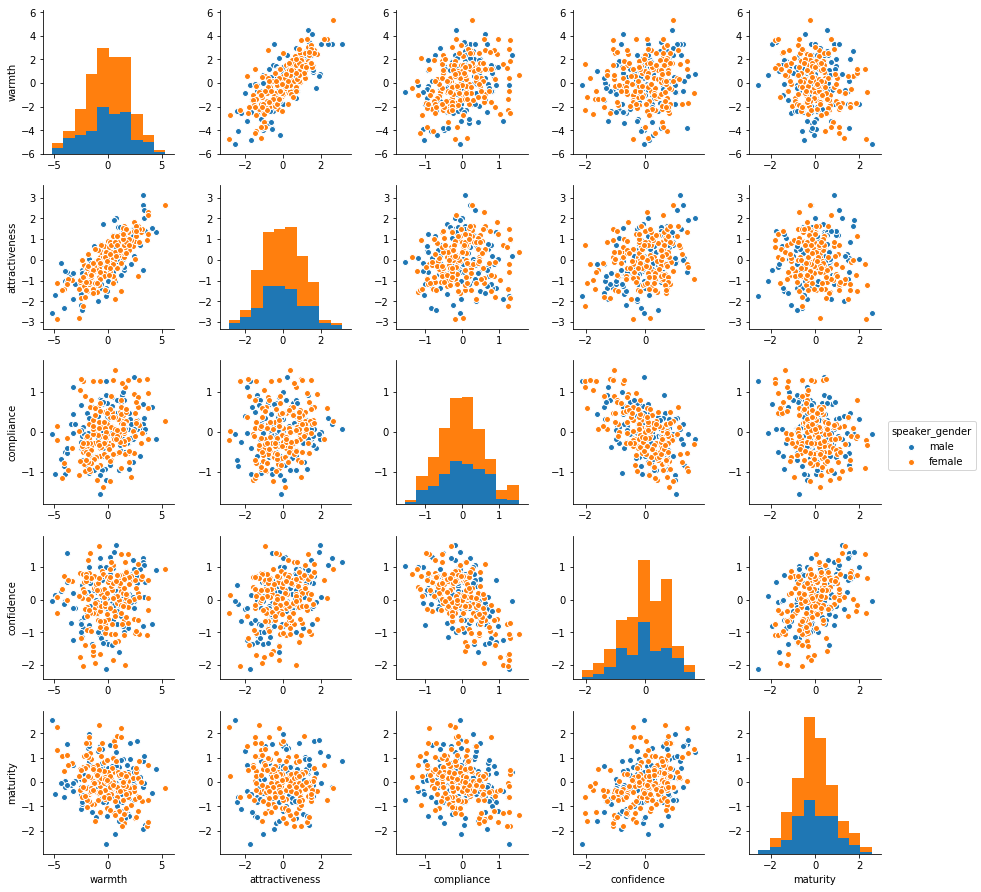

In [5]:
# pairplot of the 5 traits

myfig = sns.pairplot(scores.drop('spkID', axis=1), hue='speaker_gender', hue_order=['male','female'])
filename = r'\pairplot_traits_allspeakers.png'
# myfig.savefig(r'.\figures' + filename, bbox_inches = 'tight')  

WAAT (warmth-attractiveness) are the first two dimensions of the perceived speaker characteristics. Scaled scores (with mean = 0 and std = 1) of speakers on these dimensions were already extracted in the [subjective analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics), for males and for females separately.

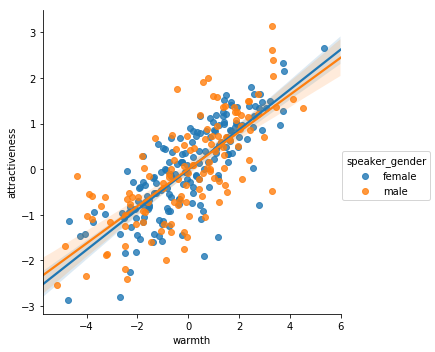

In [6]:
# scatter plot

sns.lmplot('warmth', 'attractiveness', data = scores, hue="speaker_gender") 

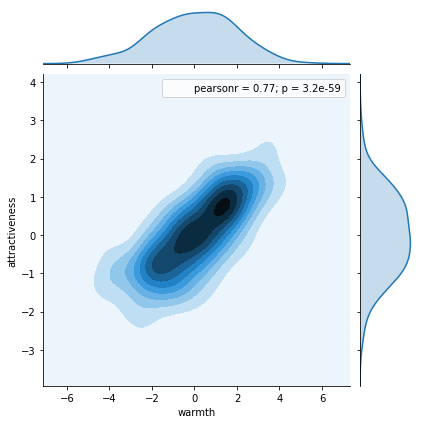

In [7]:
# histogram, kernel density estimation
sns.jointplot('warmth', 'attractiveness', data = scores, kind="kde").set_axis_labels("warmth", "attractiveness")

Get 3 clusters of speakers based on the WAAT distribution.
Each cluster with approx. the same number of instances.

mid     118
high    109
low      73
Name: class, dtype: int64


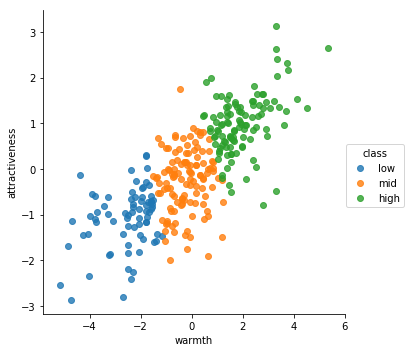

In [16]:
# applying k-means

n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scores[[traits_names[0],traits_names[1]]])

scores['class'] = pd.Categorical(kmeans.labels_).rename_categories(['high','low','mid'])

print(scores['class'].value_counts())   

myfig = sns.lmplot(traits_names[0],traits_names[1], data = scores, hue="class", hue_order = ['low','mid','high'], fit_reg=False, aspect=1)
filename = r'\kmeans3_WAAT_allspeakers.png'
# myfig.savefig(r'.\figures' + filename, bbox_inches = 'tight')  


**Removing** speakers in the mid class to address binary classification.

**Split speakers** into train (75%) and test (25%) speakers with class and gender balance (stratified) by creating the dummy "gendertrait" class.

In [9]:
# remove speakers in the mid class

scores = scores.loc[ scores['class'] != 'mid', ['spkID','speaker_gender','class']]

scores['class'] = pd.Categorical(scores['class'], categories=['low','high'])

print(scores.head())

print(scores.groupby(['speaker_gender','class']).count())

   spkID speaker_gender class
0      1         female  high
2      3         female   low
3      4           male   low
4      5           male   low
5      6           male  high
                      spkID
speaker_gender class       
female         low       72
               high      57
male           low       46
               high      46


In [ ]:
# get stratified random partition for train and test

scores['genderclass']=scores[['speaker_gender', 'class']].apply(lambda x: ''.join(x), axis=1)

indexes = np.arange(0,len(scores))
classes = scores['class']
train_i, test_i, train_y, test_y = train_test_split(indexes, 
                                                    classes, 
                                                    test_size=0.25, 
                                                    stratify = scores['genderclass'], 
                                                    random_state=2302)

scores_train = scores.iloc[train_i,:] 
scores_test = scores.iloc[test_i,:] 

print(scores_train['genderclass'].value_counts())
print(scores_test['genderclass'].value_counts())

# save these data for other evaluations
# scores.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_all.csv', index=False)
# scores_train.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_train.csv', index=False)
# scores_test.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_test.csv', index=False)

# Number of speakers in Train: 137
# Number of speakers in Test: 46
# Number of w-high speakers in Train: 43
# Number of m-high speakers in Train: 34
# Number of w-low speakers in Train: 34
# Number of m-low speakers in Train: 26
# Number of w-high speakers in Test: 15
# Number of m-high speakers in Test: 12
# Number of w-low speakers in Test: 11
# Number of m-low speakers in Test: 8

In [11]:
# merge features and scores train/test

feats_class_train = feats_ratings_scores_all.merge(scores_train) 
feats_class_test = feats_ratings_scores_all.merge(scores_test) 

Pre-processing features with the transformation **learnt with training data**:

* center and scale speech features

In [12]:
# Standardize speech features  

dropcolumns = ['name','spkID','speaker_gender','class','genderclass'] + items_names + traits_names

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_class_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_class_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_class_test.drop(dropcolumns, axis=1)) 


## Model tuning with feature selection

Use the train data to find the classifier and its hyperparameters leading to the best performance. 

Perform feature selection with "SelectKBest": selecting best k features based on ANOVA F-value computed between class label and feature. 

My procedure:

* Choose data (feature and labels) for train X and y and test Xt and yt
* Split train data into A and B sets
* Hyperparameter tuner using A and B sets data by calling hp_tuner()
    * For each classifier type:
        * Stratified cross-validation for hyperparameter tuning using set A
        * Evaluate the performance on set B
* Select classifier based on the best performance on set B and train it using all training data   
* Get performance on test set

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))

(hp_tuner() in cls_tuning.py)

In [ ]:
# training data. Features and labels
X = feats_s_train
y = feats_class_train['class'].cat.codes

# test data. Features and labels
Xt = feats_s_test
yt = feats_class_test['class'].cat.codes

# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_class_train['genderclass'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])
    

In [10]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

# label: str to keep track of the different runs in the filename
label=''

In [ ]:
# save splits

# original features and class
feats_class_train.to_csv(r'.\data_while_tuning\feats_class_train.csv', index=False)
feats_class_test.to_csv(r'.\data_while_tuning\feats_class_test.csv', index=False)

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X.npy', X)
np.save(r'.\data_while_tuning\y.npy', y)
np.save(r'.\data_while_tuning\Xt.npy', Xt)
np.save(r'.\data_while_tuning\yt.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX.npy', AX)
np.save(r'.\data_while_tuning\BX.npy', BX)
np.save(r'.\data_while_tuning\Ay.npy', Ay)
np.save(r'.\data_while_tuning\By.npy', By)

### Calling hp_tuner() for each classifier

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [12]:

# original features and class
feats_class_train = pd.read_csv(r'.\data_while_tuning\feats_class_train.csv')
feats_class_test = pd.read_csv(r'.\data_while_tuning\feats_class_test.csv')
feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header=None)
feats_names = feats_names.values.tolist()

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X.npy')
y = np.load(r'.\data_while_tuning\y.npy')
Xt = np.load(r'.\data_while_tuning\Xt.npy')
yt = np.load(r'.\data_while_tuning\yt.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX.npy')
BX = np.load(r'.\data_while_tuning\BX.npy')
Ay = np.load(r'.\data_while_tuning\Ay.npy')
By = np.load(r'.\data_while_tuning\By.npy')

# label: str to keep track of the different runs in the filename
label=''

In [15]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning(label)

Call this after each experiment **to recover later**:

In [30]:
# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all, label)

#### GaussianNB

*class sklearn.naive_bayes.GaussianNB(priors=None)*

No parameters to tune for this classifier. Priors not specified, so they will be adjusted given the data.

In [14]:
from sklearn.naive_bayes import GaussianNB

"""
Naive Bayes Classifier
"""
def get_GaussianNB2tune():

    model = GaussianNB()
    hp = dict()
    return 'GaussianNB', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_GaussianNB2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'GaussianNB' -> Best cross-val score on A set: 0.685354 using {'selecter__k': 37}
'GaussianNB' -> Selected features: []
'GaussianNB' -> Average per-class accuracy on B set: 0.690090



0     {'selecter__k': 2}
1     {'selecter__k': 7}
2    {'selecter__k': 12}
3    {'selecter__k': 17}
4    {'selecter__k': 22}
Name: params, dtype: object


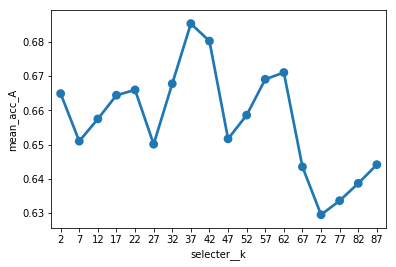

In [15]:
# open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\GaussianNB_tuning.csv')
print(sgrid['params'].head())

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. k
sns.pointplot(x='selecter__k', y='mean_acc_A', data=sgrid.join(params_df)) 

Not so good performance with naive bayes, and no trend can be seen to detect which number of selected features is better.

#### LogisticRegression

*class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)*

Tuning C (inverse of regularization strength). The 'liblinear' solver (a good choice for small datasets) handles L1 penalty.


In [16]:
from sklearn.linear_model import LogisticRegression

"""
Logistic Regression
"""
def get_LogisticRegression2tune():

    model = LogisticRegression()
    hp = dict(
        #classifier__penalty = ['l1','l2'],
        classifier__C = np.logspace(-3,3,num=7)
    )
    return 'LogisticRegression', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_LogisticRegression2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'LogisticRegression' -> Best cross-val score on A set: 0.756037 using {'classifier__C': 10.0, 'selecter__k': 87}
'LogisticRegression' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'LogisticRegression' -> Average per-class accuracy on B set: 0.753022



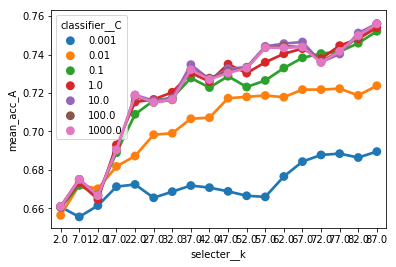

In [17]:
# open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\LogisticRegression_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df)) 

Including more features is beneficial for the performance of logistic regression. Similar behavior when C >= 0.1

#### K Nearest Neighbors

*class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)*

Tuning number of neighbors.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

"""
K Nearest Neighbors
"""
def get_KNeighborsClassifier2tune():

    model = KNeighborsClassifier()
    hp = dict(
        classifier__n_neighbors = list(range(1,40))
    )
    return 'KNeighborsClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_KNeighborsClassifier2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsClassifier' -> Best cross-val score on A set: 0.901192 using {'classifier__n_neighbors': 4, 'selecter__k': 67}
'KNeighborsClassifier' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'KNeighborsClassifier' -> Average per-class accuracy on B set: 0.870721



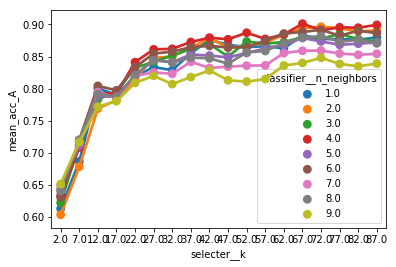

In [19]:
# open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
params_df = params_df.loc[params_df['classifier__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_neighbors', data=sgrid.join(params_df)) 

The performance of KNN classifiction tends to be better with more features with 6 neighbors or less.

#### Support Vector Machines

*class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)*

I create a different function for each kernel. Tuning C (Penalty of the error term), degree (for 'poly' only), and gamma. 

In [6]:
from sklearn.svm import SVC

"""
Support Vector Machines
"""
def get_SVClinear2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,3,num=9),
        classifier__kernel = ['linear']
    )
    return 'SVClinear', model, hp

def get_SVCpoly2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-4,2,num=7),
        classifier__kernel = ['poly'],
        classifier__degree = [2,3,4,5], 
        classifier__gamma = ['auto']#,np.logspace(-5,2,num=8)]
    )
    return 'SVCpoly', model, hp

def get_SVCrbf2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,5,num=20),
        classifier__kernel = ['rbf'],
        classifier__gamma = np.logspace(-5,5,num=20)
    )
    return 'SVCrbf', model, hp

def get_SVCsigmoid2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,3,num=9),
        classifier__kernel = ['sigmoid'],
        classifier__gamma = np.logspace(-5,3,num=9)
    )
    return 'SVCsigmoid', model, hp


In [ ]:
# Hyperparameter tuning with SVM with different kernels
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVClinear2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

In [15]:
# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVCpoly2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

'SVCpoly' -> Best cross-val score on A set: 0.878826 using {'classifier__C': 10.0, 'classifier__degree': 3, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly', 'selecter__k': 62}
'SVCpoly' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'SVCpoly' -> Average per-class accuracy on B set: 0.850282



From now on, hyperparameter tuning with RandomizedSearchCV 

In [14]:
# tune with rbf kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVCrbf2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

'SVCrbf' -> Best cross-val score on A set: 0.749107 using {'selecter__k': 79, 'classifier__kernel': 'rbf', 'classifier__gamma': 0.00037926901907322499, 'classifier__C': 20.691380811147901}
'SVCrbf' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_percentile80.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFalli

In [7]:
# tune with sigmoid kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVCsigmoid2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

'SVCsigmoid' -> Best cross-val score on A set: 0.734930 using {'selecter__k': 68, 'classifier__kernel': 'sigmoid', 'classifier__gamma': 1.0000000000000001e-05, 'classifier__C': 1000.0}
'SVCsigmoid' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sma3_stddevNorm'"], ["'mfcc1_sma3_amean'"], ["'mfcc1_sma3_

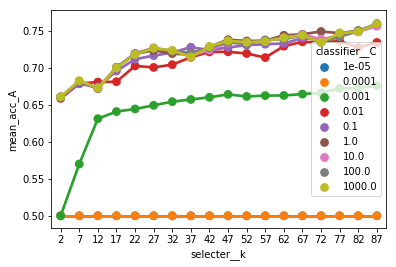

In [15]:
# Linear kernel: open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVClinear_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df)) 

In [18]:
# Poly kernel: open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCpoly_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

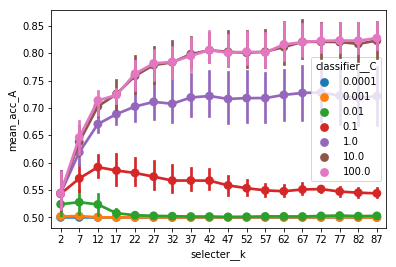

In [27]:
# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

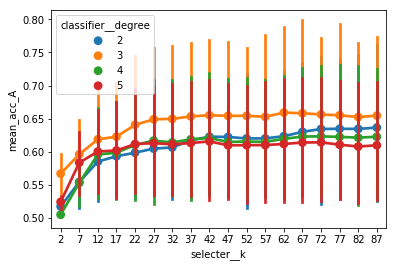

In [26]:
# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__degree', data=sgrid.join(params_df))

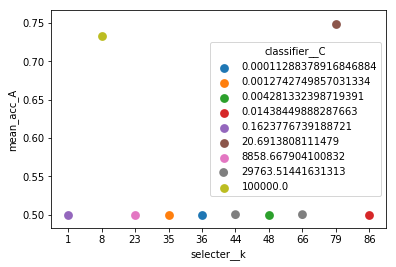

In [33]:
# rbf kernel: open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCrbf_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

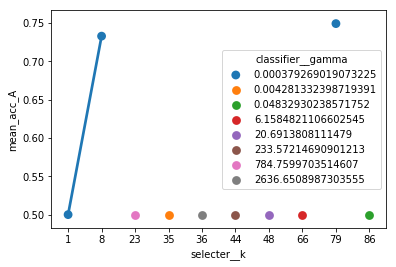

In [34]:

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__gamma', data=sgrid.join(params_df))

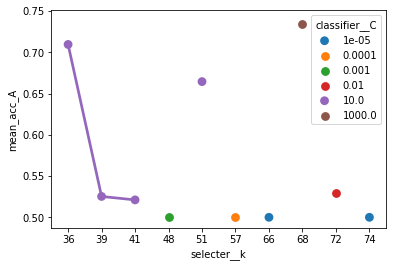

In [36]:
# sigmoid kernel: open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCsigmoid_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

Parameters leading to better performance of SVC with different kernels:

* 'linear': C >= 0.1 and high number of features. Hp tuner selected C= 0.1 and k= 87. Performance on B = 0.74
* 'poly': C >= 10, degree = 3, and high number of features. Hp tuner selected C= 10, degree = 3, and k= 62. Performance on B = 0.85
* 'rbf': Hp tuner selected C= 20, gamma = 4e-4, and k= 79. Performance on B = 0.75
* 'sigmoid': Hp tuner selected C= 1e3, gamma = 1e-5, and k= 68. Performance on B = 0.73


Fine tuning of SVC with rbf kernel after the random search. Best C could be from 1 to 100, gamma around 1e-5 and 1e-3, and n features >=50.

In [15]:
from sklearn.svm import SVC

def get_SVCrbf2finetune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.arange(1,100,5),
        classifier__kernel = ['rbf'],
        classifier__gamma = np.logspace(-5,-3,num=3)
    )
    return 'SVCrbf', model, hp

k_gridsearch = np.arange(50, 88, 1)


tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_SVCrbf2finetune], 
                               feats_names, 
                               k_gridsearch,
                               'random',
                               n_iter=100
                              )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)


'SVCrbf' -> Best cross-val score on A set: 0.851224 using {'selecter__k': 84, 'classifier__kernel': 'rbf', 'classifier__gamma': 0.001, 'classifier__C': 86}
'SVCrbf' -> Average per-class accuracy on B set: 0.830593



Still SVC with rbf kernel does not outperform knn

#### DecisionTreeClassifier

*class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)*

In [38]:
from sklearn.tree import DecisionTreeClassifier

"""
Decision Trees
"""
def get_DecisionTreeClassifier2tune():
    
    model = DecisionTreeClassifier(random_state=2302)
    hp = dict(
        classifier__max_depth = np.arange(30,50),
        classifier__min_samples_leaf=np.arange(1,4)
    )
    return 'DecisionTreeClassifier', model, hp

k_gridsearch = np.arange(2, 89, 5)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_DecisionTreeClassifier2tune], 
                               feats_names, 
                               k_gridsearch,
                               'grid',
                               n_iter=10
                              )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'DecisionTreeClassifier' -> Best cross-val score on A set: 0.741132 using {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 3, 'selecter__k': 82}
'DecisionTreeClassifier' -> Average per-class accuracy on B set: 0.690109



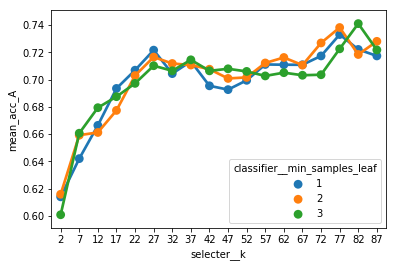

In [41]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\DecisionTreeClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__min_samples_leaf', data=sgrid.join(params_df))

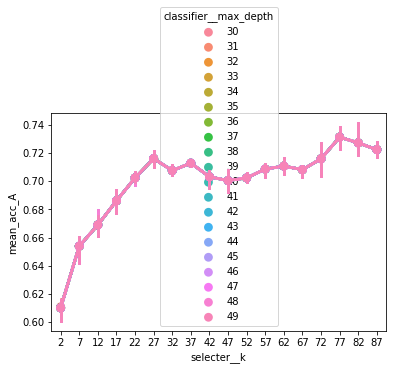

In [42]:
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__max_depth', data=sgrid.join(params_df))

After a couple of wide random searchers, I found that max_depth of around 40 and allowing for low min_samples_leaf work best. Accuracies obtained on the B set were always around 0.70.

The final gridsearch reveals that low_min_samples_leaf have a similar effect on the performance, and that feature selection plays a more important role than max_depth. There is, however, overfitting.

Still, the performance is far below svm or knn.

#### RandomForestClassifier

*class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)*

max_features=n_features (of the k best selected)

Tuning: n_estimators (number of trees in the forest), 

In [7]:
from sklearn.ensemble import RandomForestClassifier

"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier(random_state=2302, max_features = None)
    hp = dict(
        classifier__n_estimators = np.arange(2,10)
    )
    return 'RandomForestClassifier', model, hp

k_gridsearch = np.arange(2, 89)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_RandomForestClassifier2tune], 
                               feats_names, 
                               k_gridsearch,
                               'grid',
                               n_iter=10
                              )

'RandomForestClassifier' -> Best cross-val score on A set: 0.803948 using {'classifier__n_estimators': 9, 'selecter__k': 76}
'RandomForestClassifier' -> Average per-class accuracy on B set: 0.774625



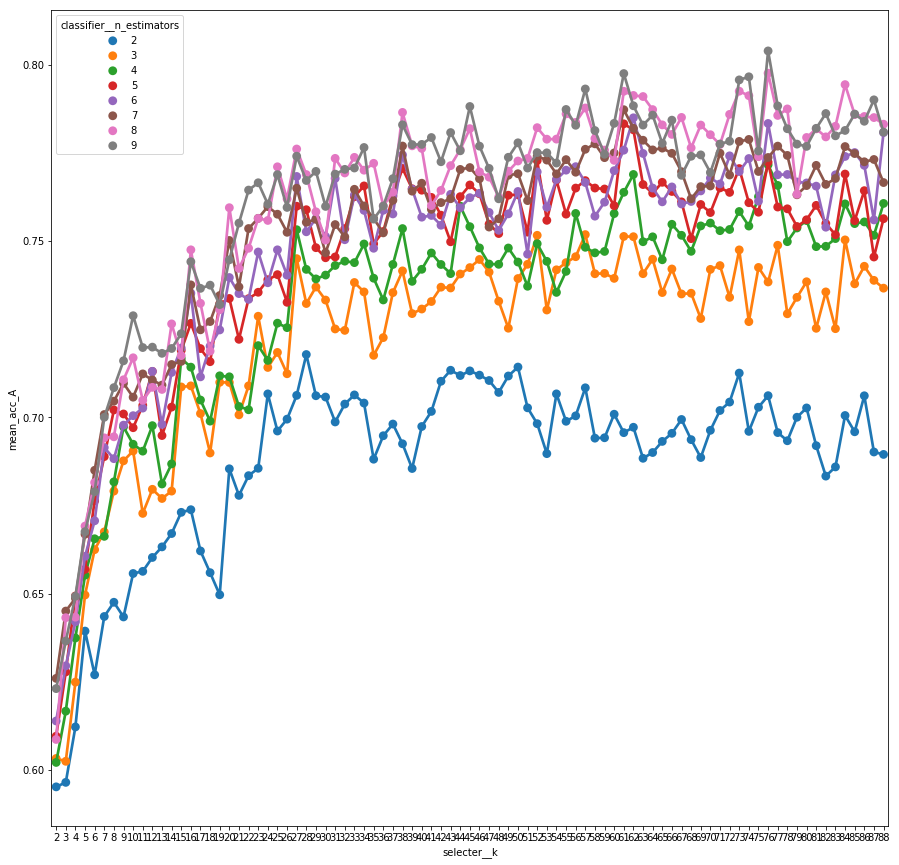

In [12]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\RandomForestClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
fig, ax = plt.subplots(figsize=(15,15))
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_estimators', data=sgrid.join(params_df))

Better performance with k > 30 and estimators >= 8. Let us gridtune again with more estimators.

In [13]:
from sklearn.ensemble import RandomForestClassifier

"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier(random_state=2302, max_features = None)
    hp = dict(
        classifier__n_estimators = np.arange(8,20)
    )
    return 'RandomForestClassifier', model, hp

k_gridsearch = np.arange(30, 89)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_RandomForestClassifier2tune], 
                               feats_names, 
                               k_gridsearch,
                               'grid',
                               n_iter=10
                              )

'RandomForestClassifier' -> Best cross-val score on A set: 0.822464 using {'classifier__n_estimators': 18, 'selecter__k': 85}
'RandomForestClassifier' -> Average per-class accuracy on B set: 0.786956



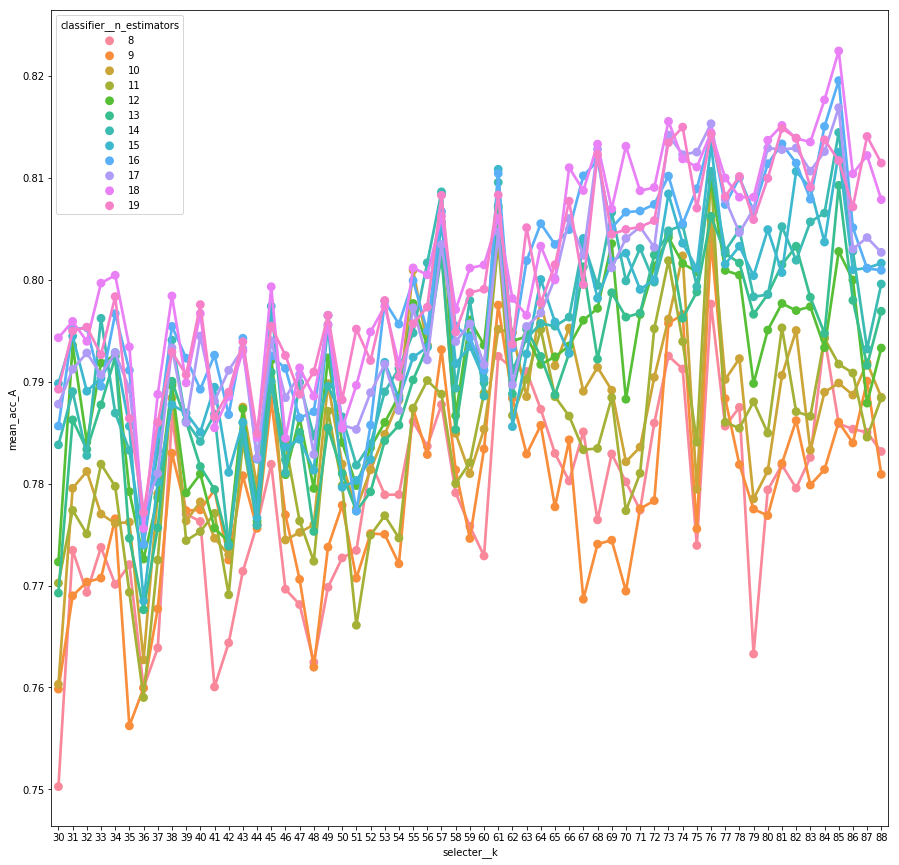

In [14]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\RandomForestClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
fig, ax = plt.subplots(figsize=(15,15))
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_estimators', data=sgrid.join(params_df))

Again, better performance with more features (k > 70) and more estimators (>= 19). Let us randomtune with more estimators.

In [19]:
from sklearn.ensemble import RandomForestClassifier

"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier(random_state=2302, max_features = None)
    hp = dict(
        classifier__n_estimators = np.arange(27,35)
    )
    return 'RandomForestClassifier', model, hp

k_gridsearch = np.arange(70, 89)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_RandomForestClassifier2tune], 
                               feats_names, 
                               k_gridsearch,
                               'random',
                               n_iter=50
                              )

'RandomForestClassifier' -> Best cross-val score on A set: 0.830468 using {'selecter__k': 76, 'classifier__n_estimators': 32}
'RandomForestClassifier' -> Average per-class accuracy on B set: 0.787350



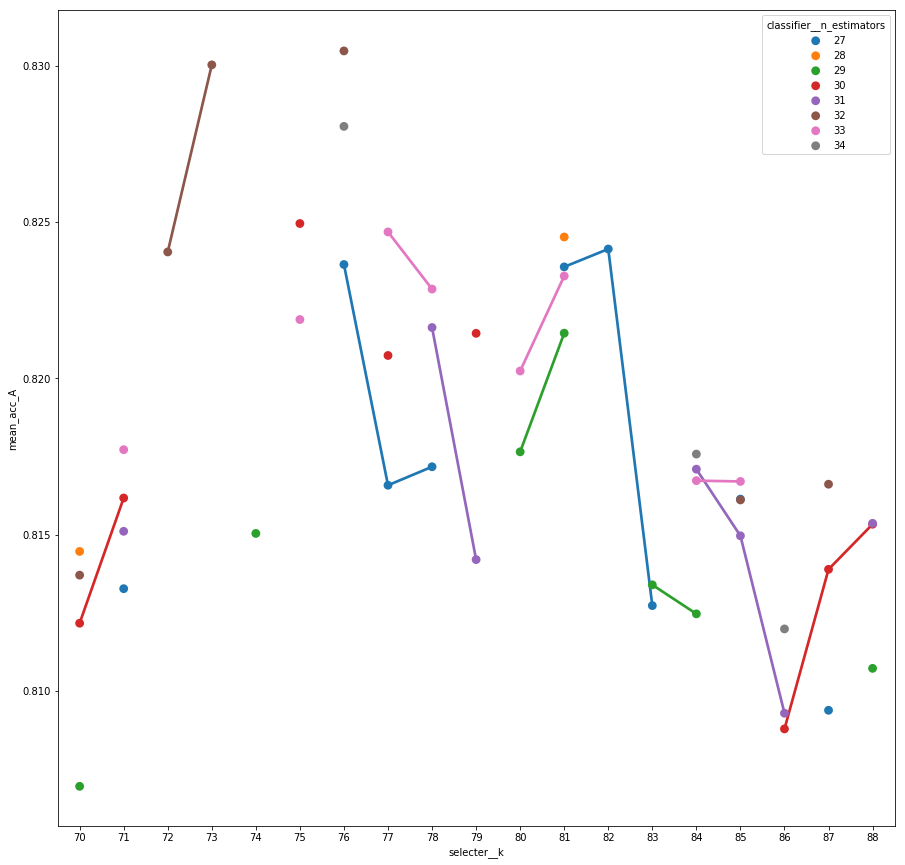

In [20]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\RandomForestClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
fig, ax = plt.subplots(figsize=(15,15))
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_estimators', data=sgrid.join(params_df))

This complex RF model with ~ 32 estimators still does not outperform knn.

Add baseline performance.

In [24]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform')
model.fit(AX, Ay)
By_pred = model.predict(BX)
score_on_B = recall_score(By, By_pred, average='macro')
d = {
    'classifiers_names': ['DummyClassifier'],
    'best_accs': score_on_B,
    'best_hps': '',
    'sel_feats': '',
    'sel_feats_i': ''
    }

tuning = pd.DataFrame(data = d)
trained = model.fit(X, y)

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append([trained])

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, label)

## Performance on test

Testing the best model found after hyperparameter tuning.

Performance metric: average per-class accuracy (see above).

We would choose the classifier giving the highest performance on the B set for a real-world application. Here, I will also compute the performance for each of the trained classifiers and plot the WAAT space with correct and incorrect predictions and point size based on the decision confidence.

In [27]:
# original features and class
feats_class_train = pd.read_csv(r'.\data_while_tuning\feats_class_train.csv')
feats_class_test = pd.read_csv(r'.\data_while_tuning\feats_class_test.csv')
feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header=None)
feats_names = feats_names.values.tolist()

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X.npy')
y = np.load(r'.\data_while_tuning\y.npy')
Xt = np.load(r'.\data_while_tuning\Xt.npy')
yt = np.load(r'.\data_while_tuning\yt.npy')

# Loading outpus of hp tuning from disk
label=''
tuning_all, trained_all = load_tuning(label)
tuning_all

,best_accs,best_hps,classifiers_names,regressors_names,sel_feats,sel_feats_i
0,0.690090,{'selecter__k': 37},GaussianNB,NaN,"[""'F0semitoneFrom27.5Hz_sma3nz_amean'"", ""'F0se...",[False True False False True True False Fal...
1,0.753022,"{'classifier__C': 10.0, 'selecter__k': 87}",LogisticRegression,NaN,"[""'F0semitoneFrom27.5Hz_sma3nz_amean'"", ""'F0se...",[ True True True True True True True Tr...
2,0.870721,"{'classifier__n_neighbors': 4, 'selecter__k': 67}",KNeighborsClassifier,NaN,"[""'F0semitoneFrom27.5Hz_sma3nz_amean'"", ""'F0se...",[ True True False True True True True Tr...
3,0.737594,"{'classifier__C': 0.10000000000000001, 'classi...",SVClinear,NaN,"[""'F0semitoneFrom27.5Hz_sma3nz_amean'"", ""'F0se...",[ True True True True True True True Tr...
4,0.850282,"{'classifier__C': 10.0, 'classifier__degree': ...",SVCpoly,NaN,"[""'F0semitoneFrom27.5Hz_sma3nz_amean'"", ""'F0se...",[ True True False True True True True Tr...
5,0.752252,"{'selecter__k': 79, 'classifier__kernel': 'rbf...",SVCrbf,NaN,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
6,0.729880,"{'selecter__k': 68, 'classifier__kernel': 'sig...",SVCsigmoid,NaN,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True False True True True True Tr...
7,0.830593,"{'selecter__k': 84, 'classifier__kernel': 'rbf...",SVCrbf,NaN,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
8,0.690109,"{'classifier__max_depth': 30, 'classifier__min...",DecisionTreeClassifier,NaN,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
9,0.787350,"{'selecter__k': 76, 'classifier__n_estimators'...",RandomForestClassifier,NaN,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True False True True True True Tr...


In [28]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmax()

print('Selected classifier based on the best performance on B: %r (accB = %0.2f)' % (tuning_all.loc[i_best,'classifiers_names'], round(best_accs[i_best],2)))

Selected classifier based on the best performance on B: 'KNeighborsClassifier' (accB = 0.87)


In [29]:
def mj_preds(yt, yt_pred):
    """
    Majority voting of class predictions of instances, grouped by speakers

    Input:
    - yt: true class for all instances
    - yt_pred: predicted class for all instances

    Output:
    - yt: true class per speaker
    - yt_pred_spk: predicted class per speaker
    - yt_pred_spk_conf: conf measure for the prediction per speaker, ranging from 0 to 1
    """
    # new df with true and predicted classes
    test_scores = pd.DataFrame(data = feats_class_test[['spkID','class']])
    test_scores['yt'] = yt
    test_scores['yt_pred'] = yt_pred

    # group by speakers and compute prediction confidence based on the distance from 0.5
    test_scores_spk = test_scores.groupby('spkID').mean()
    conf = abs(0.5-test_scores_spk)/0.5
    yt_pred_spk_conf = conf['yt_pred']

    # compute scores after 'majority voting'
    yt_spk = test_scores_spk.round().astype(int)['yt']
    yt_pred_spk = test_scores_spk.round().astype(int)['yt_pred']

    return yt_spk, yt_pred_spk, yt_pred_spk_conf



def plot_WAAT_preds(yt_spk, yt_pred_spk, yt_pred_spk_conf, cls, avg_pc_acc):
    """
    Given the true and predicted class per speaker and confidence, plot the WAAT space
    color coded by correct/incorrect predictions, with point shape indicating the confidence
    of the prediction.

    Plot saved to disk.

    Input:
    - yt: true class per speaker
    - yt_pred_spk: predicted class per speaker
    - yt_pred_spk_conf: conf measure for the prediction per speaker, ranging from 0 to 1
    - cls: name of classifier
    - avg_pc_acc: average per-class accuracy to show on figure title
    """

    is_correct = yt_pred_spk==yt_spk

    d = {
        'yt_spk': yt_spk,
        'yt_pred_spk': yt_pred_spk,
        'yt_pred_spk_conf': yt_pred_spk_conf,
        'is_correct': is_correct
        }

    df = pd.DataFrame(data = d)
    df.reset_index(inplace=True)

    # scores of speakers of the test set
    df = df.merge(scores[['spkID','warmth','attractiveness']])

    plt.style.use(['default'])
    alpha = 0.5

    plt.figure()

    plt.scatter(df.loc[df['is_correct']==True,'warmth'], df.loc[df['is_correct']==True,'attractiveness'],
                marker="o", alpha=alpha, s=10+100*df.loc[df['is_correct']==True,'yt_pred_spk_conf'], label='correct')

    plt.scatter(df.loc[df['is_correct']==False,'warmth'], df.loc[df['is_correct']==False,'attractiveness'],
                marker="o", alpha=1, s=10+100*df.loc[df['is_correct']==False,'yt_pred_spk_conf'], label='not correct', color="red")

    plt.xlabel('warmth')
    plt.ylabel('attractiveness')
    plt.title('Binary WAAT classification with '+ cls + ', average per-class accuracy=' + str(round(avg_pc_acc,2)))
    plt.legend()

    # save plot
    filename = r'\cls_WAAT_binary_predictions_'+cls+'.png'
    plt.savefig(r'.\figures' + filename, bbox_inches = 'tight')


'GaussianNB' -> (per instance) Average per-class accuracy on B: 0.69
'GaussianNB' -> (per instance) Average per-class accuracy on test: 0.67
'GaussianNB' -> (per speaker) Average per-class accuracy on test: 0.69
[[15  4]
 [11 16]]

'LogisticRegression' -> (per instance) Average per-class accuracy on B: 0.75
'LogisticRegression' -> (per instance) Average per-class accuracy on test: 0.70
'LogisticRegression' -> (per speaker) Average per-class accuracy on test: 0.72
[[14  5]
 [ 8 19]]

'KNeighborsClassifier' -> (per instance) Average per-class accuracy on B: 0.87
'KNeighborsClassifier' -> (per instance) Average per-class accuracy on test: 0.66
'KNeighborsClassifier' -> (per speaker) Average per-class accuracy on test: 0.78
[[14  5]
 [ 5 22]]

'SVClinear' -> (per instance) Average per-class accuracy on B: 0.74
'SVClinear' -> (per instance) Average per-class accuracy on test: 0.69
'SVClinear' -> (per speaker) Average per-class accuracy on test: 0.66
[[11  8]
 [ 7 20]]

'SVCpoly' -> (per ins

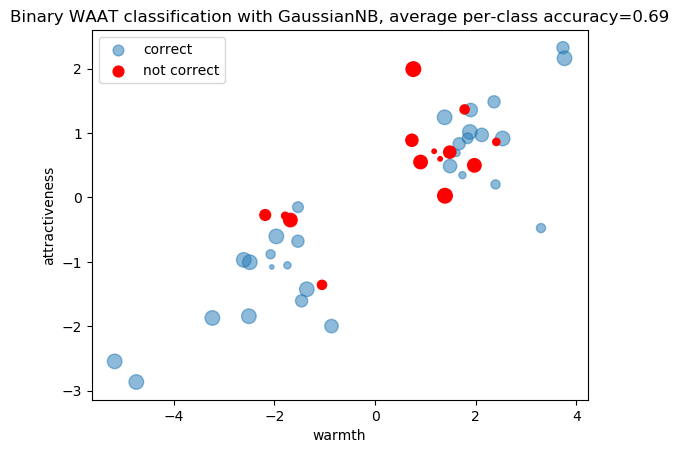

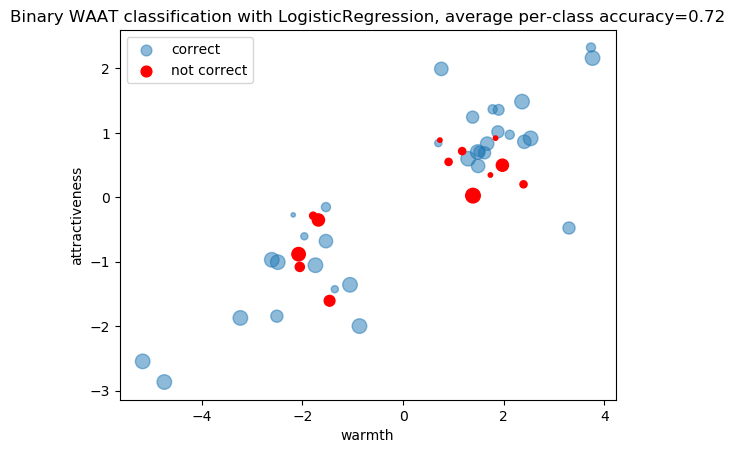

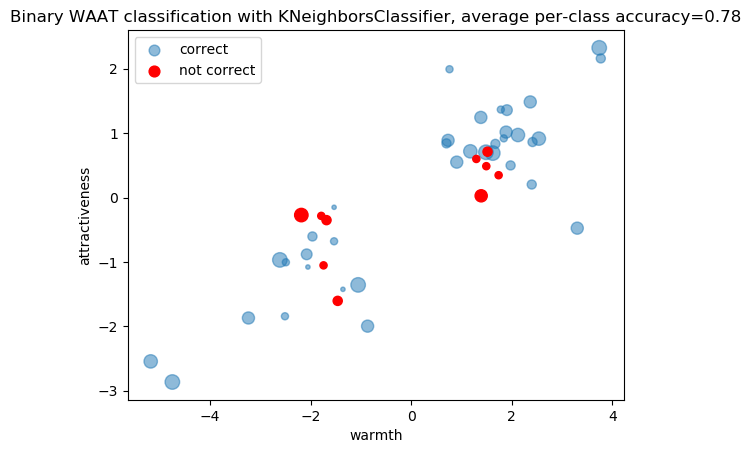

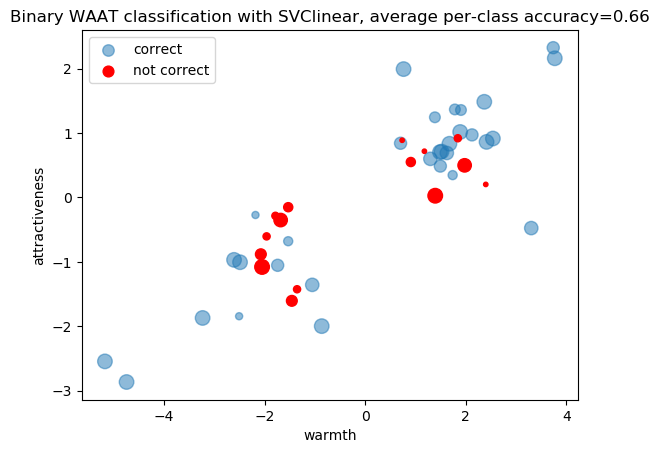

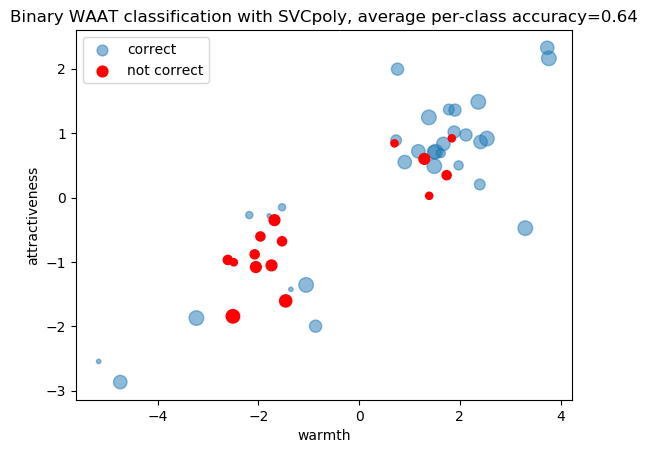

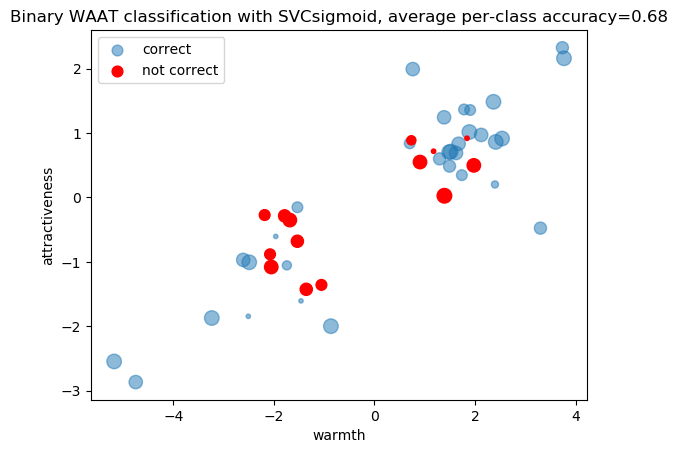

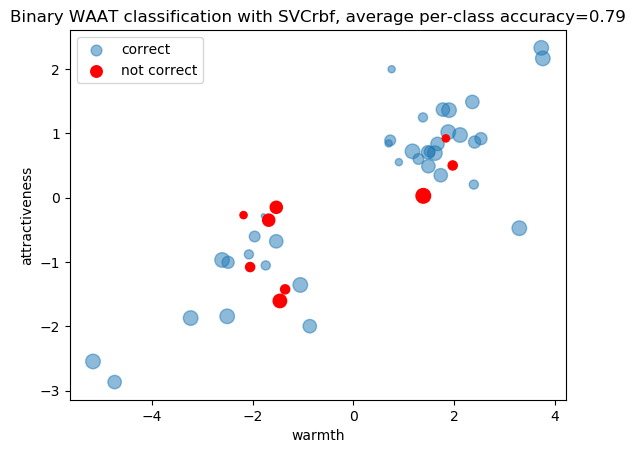

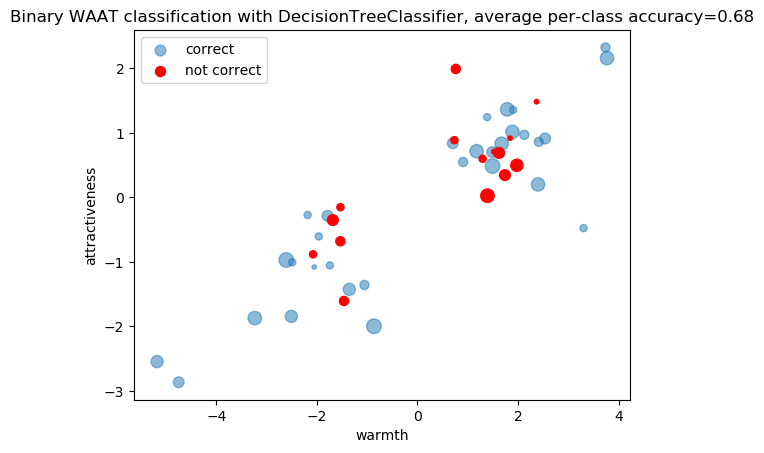

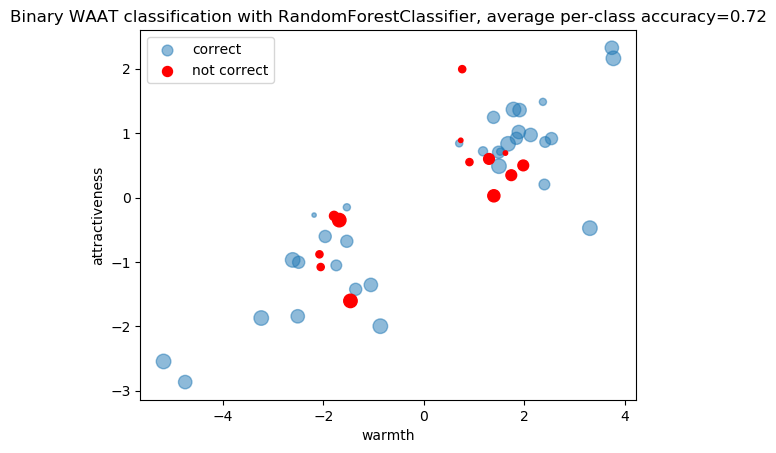

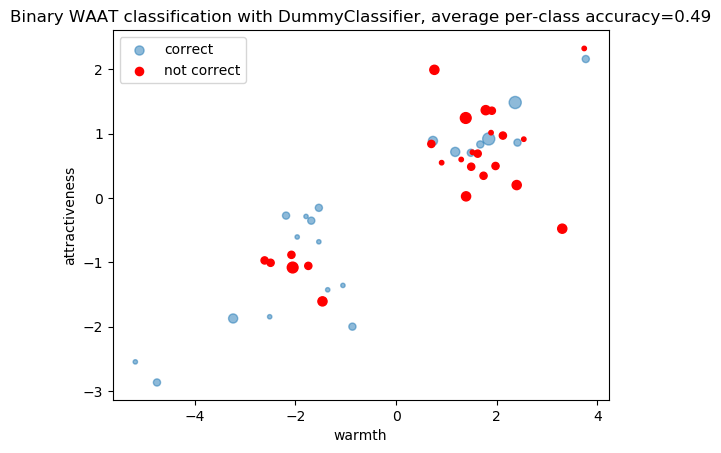

In [30]:
# go through performace on dev and on test for all classifiers


# removing duplicates from tuning_all (same classifier tuned twice with different searchers)
indexes = tuning_all['classifiers_names'].drop_duplicates(keep='last').index.values

# dataframe for summary of performances
performances = pd.DataFrame(tuning_all.loc[indexes,['classifiers_names','best_accs']])


for i in indexes:

    yt_pred = trained_all[i][0].predict(Xt)

    # score per instance
    score_on_test = recall_score(yt, yt_pred, average='macro')

    # score per speaker
    yt_spk, yt_pred_spk, yt_pred_spk_conf = mj_preds(yt, yt_pred)
    score_on_test_spk = recall_score(yt_spk, yt_pred_spk, average='macro')

    print("%r -> (per instance) Average per-class accuracy on B: %.2f" % (tuning_all.loc[i,'classifiers_names'], tuning_all.loc[i,'best_accs'])) 
    print("%r -> (per instance) Average per-class accuracy on test: %.2f" % (tuning_all.loc[i,'classifiers_names'], score_on_test)) 
    print("%r -> (per speaker) Average per-class accuracy on test: %.2f" % (tuning_all.loc[i,'classifiers_names'], score_on_test_spk)) 

    performances.loc[i,'score_on_test']=score_on_test
    performances.loc[i,'score_on_test_spk']=score_on_test_spk   
                                           
    cm = confusion_matrix(yt_spk, yt_pred_spk)
    print(cm)
    print("")
    
    # generate plot of the WAAT space with the confidence of the predictions
    plot_WAAT_preds(yt_spk, yt_pred_spk, yt_pred_spk_conf, tuning_all.loc[i,'classifiers_names'], score_on_test_spk)

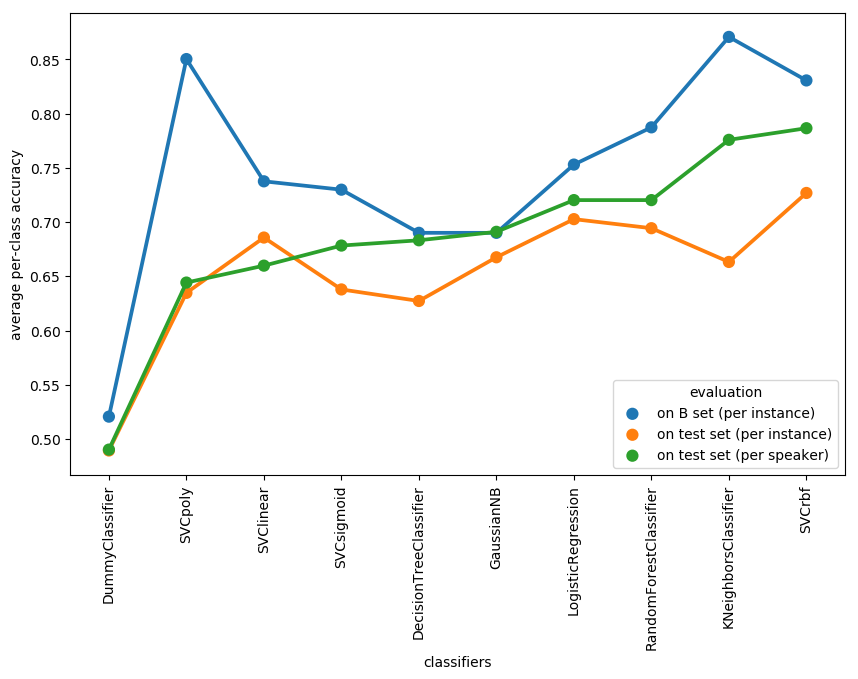

In [32]:
# pointplot performance

performances = performances.rename(index=str, columns={
    'classifiers_names':'classifiers',
    'best_accs':'on B set (per instance)',
    'score_on_test':'on test set (per instance)',
    'score_on_test_spk':'on test set (per speaker)'
})

# sort by 'on test set (per speaker)' column
performances_sorted = performances.sort_values(['on test set (per speaker)']).reset_index()

performances_melt = pd.melt(performances_sorted, id_vars=['classifiers'], value_vars=['on B set (per instance)',
                                                                               'on test set (per instance)',
                                                                               'on test set (per speaker)'])
performances_melt.rename(columns={
    'value':'average per-class accuracy',
    'variable': 'evaluation'
}, inplace=True)

fig, ax = plt.subplots(figsize=[10, 6])
myfig=sns.pointplot(x='classifiers', y='average per-class accuracy', hue='evaluation', data=performances_melt);
        
# rotate x axis and limit y axis
for item in myfig.get_xticklabels():
    item.set_rotation(90)
    
# save plot
filename = r'\cls_WAAT_binary_performance.png'
plt.savefig(r'.\figures' + filename, bbox_inches = 'tight')

A severe drop in accuracy can be seen comparing performance in development and in the test sets. The test set is challenging, since these are 'unseen' speakers. 

Best performance on test (per instance) is given by SVCrbf (0.73), not by the knn (0.66). The knn was clearly overfit to the speakers of the training and dev sets, and would be a good choice if the train and test speakers were the same ones.

Performing majority voting tends to improve the average per-class accuracy on test. This would be possitble in applications where the identity of speakers is known beforehand. In this case, the best and second-best classifiers are SVCrbf (0.79) and knn (0.78). 

Interestingly, it can be seen from the plots that incorrectly predicted speakers are close to the border between the high and los classes. Extreme speakers are generally well predicted. In the case of SVCrbf, more speakers with low WAAT are incorrectly classified compared to those of high WAAT. 